In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

/home/xery/py2venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

In [3]:
cd ~/proj/datan/p5_enron/

/home/xery/proj/datan/p5_enron


In [4]:
ls

enron61702insiderpay.pdf            poi_email_addresses.py
final_project_dataset_modified.pkl  poi_id.py*
final_project_dataset.pkl           poi_names.txt
my_classifier.pkl                   py2venv-requirements.txt
my_dataset.pkl                      tester.py
my_feature_list.pkl                 tester.pyc
p5_enron.ipynb                      tools/


In [5]:
d=pickle.load(open("final_project_dataset.pkl"))

Number of records

In [6]:
len(d)

146

Number of features

In [7]:
len(d.items()[0][1])

21

In [8]:
d.items()[0][1]

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

In [9]:
df=pd.DataFrame.from_dict(d, orient='index', dtype=np.float)

In [10]:
df.dtypes

salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
exercised_stock_options      float64
bonus                        float64
restricted_stock             float64
shared_receipt_with_poi      float64
restricted_stock_deferred    float64
total_stock_value            float64
expenses                     float64
loan_advances                float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                          float64
director_fees                float64
deferred_income              float64
long_term_incentive          float64
email_address                 object
from_poi_to_this_person      float64
dtype: object

Explicitly assigning np.NaN to the 'email_address' column, since if it is empty it contains a 'NaN' in the form of a string that is not recognized by pd.isnull()

In [11]:
df.loc[df.email_address == 'NaN', 'email_address'] = np.NaN

Are there any records containing only 'NaN's (the 'poi' target label is to be excluded)?

In [12]:
df.ix[:,df.columns != 'poi'].isnull().all(1).any()

True

Who's that guy?

In [13]:
df[df.ix[:,df.columns != 'poi'].isnull().all(1)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


Are there any records without a 'NaN' column?

In [14]:
df.notnull().all(1).any()

False

Count how many of the 20 features are NaNs for each person.

In [15]:
nan_per_person = df.isnull().sum(1).sort_values(ascending=False)
nan_per_person

LOCKHART EUGENE E                20
GRAMM WENDY L                    18
WROBEL BRUCE                     18
WHALEY DAVID A                   18
THE TRAVEL AGENCY IN THE PARK    18
WAKEHAM JOHN                     17
WODRASKA JOHN                    17
CLINE KENNETH W                  17
GILLIS JOHN                      17
SCRIMSHAW MATTHEW                17
SAVAGE FRANK                     17
MENDELSOHN JOHN                  16
YEAP SOON                        16
CHRISTODOULOU DIOMEDES           16
PEREIRA PAULO V. FERRAZ          16
BLAKE JR. NORMAN P               16
LOWRY CHARLES P                  16
CHAN RONNIE                      16
MEYER JEROME J                   16
GATHMANN WILLIAM D               16
WINOKUR JR. HERBERT S            16
FUGH JOHN L                      16
URQUHART JOHN A                  16
NOLES JAMES L                    15
WALTERS GARETH W                 15
BADUM JAMES P                    15
LEMAISTRE CHARLES                15
DUNCAN JOHN H               

How many people have NaNs in more than half of the features?

In [16]:
nan_per_person[nan_per_person >= 10].count()

69

Let's plot in a very informal way the numeric columns, just to get a feeling about the data magnitudes.

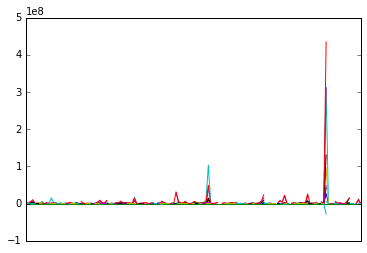

In [17]:
df.loc[:,df.dtypes==np.float].plot(legend=False, xticks=())

Looks like there is a record that is very different that the others... an outlier? Which one is it?

In [18]:
a=(df[df.columns[~df.columns.isin(['email_address'])]] > 3e8).any(1)
df[a]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,...,83925000.0,NaN,42667589.0,NaN,0.0,1398517.0,-27992891.0,48521928.0,NaN,NaN


Sort the columns according to the number of NaN values in them?

In [19]:
df.isnull().sum().sort_values(ascending=False)

loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_poi_to_this_person       60
shared_receipt_with_poi       60
to_messages                   60
from_this_person_to_poi       60
from_messages                 60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
email_address                 35
total_payments                21
total_stock_value             20
poi                            0
dtype: int64

Find out if the values of the non-TOTAL rows sum up correctly to the respective values in the TOTAL row

In [20]:
# Find all columns where the TOTAL row has valid values
col_where_total_is_nan = df.loc['TOTAL', df.loc['TOTAL'].notnull()]
# Also remove the POI column
col_where_total_is_nan.drop('poi', inplace=True)
# Get a view of the original DataFrame containing only the columns that carry a valid value for TOTAL
df_tot_check = df[col_where_total_is_nan.index]
# Check if the non-TOTAL rows sum up correctly to the values in the TOTAL row
a = (df_tot_check.loc[~df.index.isin(['TOTAL'])].sum() == df_tot_check.loc['TOTAL'])
# Print the column names that sum up correctly to the TOTAL
a[a==True]

salary                 True
bonus                  True
loan_advances          True
long_term_incentive    True
dtype: bool

Remove the TOTAL row and the "LOCKHART EUGENE E" row, as well as the email column.

In [21]:
df_cleaned = df.drop(['TOTAL', 'LOCKHART EUGENE E'])
del(df_cleaned['email_address'])

In [22]:
df_cleaned.shape

(144, 20)

Separating the cleaned input dataset into features and labels

In [59]:
X, y = df_cleaned.loc[:,~df_cleaned.columns.isin(['poi'])].values, df_cleaned.poi.values.astype(np.int)
names = df_cleaned.index.values
feature_names = df_cleaned.columns
print X.shape, y.shape
print feature_names

(144, 19) (144,)
Index([u'salary', u'to_messages', u'deferral_payments', u'total_payments',
       u'exercised_stock_options', u'bonus', u'restricted_stock',
       u'shared_receipt_with_poi', u'restricted_stock_deferred',
       u'total_stock_value', u'expenses', u'loan_advances', u'from_messages',
       u'other', u'from_this_person_to_poi', u'poi', u'director_fees',
       u'deferred_income', u'long_term_incentive', u'from_poi_to_this_person'],
      dtype='object')


Learning

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import pydot

Removing NaNs and choosing half of the best features

In [80]:
imputer = Imputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y = y.ravel()
print X_imputed.shape, y.shape
selector = SelectKBest(k=17, score_func=f_classif)
X_kbest = selector.fit_transform(X_imputed, y)
print sorted(selector.scores_)
print X_kbest.shape

(144, 19) (144,)
[0.096466996044551362, 0.1844478897790045, 0.26398607335380175, 0.33113407554201896, 0.88638567907732535, 1.0242232786527743, 2.223561609429177, 3.923641446787566, 4.2848243476650776, 7.3477737824157634, 7.4779387901614962, 8.4287653667034554, 8.4822770639568059, 8.486577387814604, 10.367046503394285, 10.972778462722507, 15.979606683425999, 23.67759272684032, 27.424868115330316]
(144, 17)


In [66]:
print X, X_imputed

[[  2.01955000e+05   2.90200000e+03   2.86971700e+06 ...,  -3.08105500e+06
    3.04805000e+05   4.70000000e+01]
 [             nan              nan   1.78980000e+05 ...,              nan
               nan              nan]
 [  4.77000000e+02   5.66000000e+02              nan ...,  -5.10400000e+03
               nan   3.90000000e+01]
 ..., 
 [             nan              nan              nan ...,              nan
               nan              nan]
 [  1.58403000e+05              nan              nan ...,              nan
               nan              nan]
 [             nan              nan              nan ...,              nan
               nan              nan]] [[  2.01955000e+05   2.90200000e+03   2.86971700e+06 ...,  -3.08105500e+06
    3.04805000e+05   4.70000000e+01]
 [  2.58741000e+05   1.21100000e+03   1.78980000e+05 ...,  -1.51927000e+05
    4.22158000e+05   3.50000000e+01]
 [  4.77000000e+02   5.66000000e+02   2.21063500e+05 ...,  -5.10400000e+03
    4.22158000e+05   

Comparing two Logistic regressions - on the full feature space, and on the KBest-selected one

In [131]:
n_jobs = 1
scoring = 'recall'
clf = Pipeline([('kbest', SelectKBest()), ('scaler', StandardScaler()), ('pca', PCA()), 
                ('logreg', LogisticRegression(penalty='l1', class_weight='balanced', random_state=123))])
#clf = LogisticRegression(penalty='l1', random_state=123)
X_kbest_scaled = StandardScaler().fit_transform(X_kbest)
X_imputed_scaled = StandardScaler().fit_transform(X_imputed)
#print "LogReg on KBest-selected features: ", cross_val_score(clf, X_kbest, y, n_jobs=n_jobs, scoring=scoring).mean()
#print "LogReg on all features: ", cross_val_score(clf, X_imputed, y, n_jobs=n_jobs, scoring=scoring).mean()
#print "LogReg on KBest-selected features, StdScale'd: ",cross_val_score(clf, X_kbest_scaled, y, n_jobs=n_jobs, scoring=scoring).mean()
#print "LogReg on all features, StdScale'd: ", cross_val_score(clf, X_imputed_scaled, y, n_jobs=n_jobs, scoring=scoring).mean()
n_components = [2, 4, 6,8,10,12,14,16,18]
Cs = np.logspace(-4, 4, 3)
k = [2,4,6,8,10,12,14,16,18]
cv = StratifiedShuffleSplit(y, n_iter=100, random_state=42)
grid_search = GridSearchCV(clf, dict(pca__n_components=n_components, kbest__k=k, logreg__C=Cs), 
                           cv=cv, error_score=0, scoring=scoring, n_jobs=-1)
grid_search.fit(X_imputed,y)
print grid_search.best_estimator_.get_params()
print grid_search.best_score_
print "LogReg on all features, StdScale'd: ", cross_val_score(clf, X_imputed, y, cv = StratifiedKFold(y,n_folds=5),n_jobs=n_jobs, scoring=scoring).mean()


{'logreg__fit_intercept': True, 'logreg__warm_start': False, 'logreg__verbose': 0, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'logreg__random_state': 123, 'kbest__score_func': <function f_classif at 0x7f4b9bcad410>, 'logreg': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'logreg__C': 1.0, 'logreg__max_iter': 100, 'scaler__with_mean': True, 'kbest': SelectKBest(k=12, score_func=<function f_classif at 0x7f4b9bcad410>), 'pca': PCA(copy=True, n_components=2, whiten=False), 'logreg__multi_class': 'ovr', 'pca__copy': True, 'scaler__with_std': True, 'logreg__solver': 'liblinear', 'kbest__k': 12, 'pca__whiten': False, 'logreg__n_jobs': 1, 'scaler__copy': True, 'pca__n_components': 2, 'logreg__intercept_scaling': 1, 'logreg__dual': False, 'logreg__c

In [102]:
X_kbest_scaled

array([[-0.51331215,  0.57946589,  3.50740792, ..., -4.84559485,
        -0.44143553, -0.08556797],
       [-0.11581748, -0.2539891 , -0.29053635, ...,  0.24877845,
        -0.24502562, -0.26096709],
       [-1.92363213, -0.57189475, -0.23113597, ...,  0.50413471,
        -0.24502562, -0.20250072],
       ..., 
       [-0.11581748, -0.2539891 , -0.23113597, ...,  0.24877845,
        -0.24502562, -0.26096709],
       [-0.81817052, -0.2539891 , -0.23113597, ...,  0.24877845,
        -0.24502562, -0.26096709],
       [-0.11581748, -0.2539891 , -0.23113597, ...,  0.24877845,
        -0.24502562, -0.26096709]])

Reducing dimensionality via PCA

In [103]:
pca = KernelPCA(n_components=2, kernel='rbf', gamma=100)
print X_imputed_scaled.shape
X_imputed_scaled_pca = pca.fit_transform(X_imputed_scaled, y)
X_kbest_scaled_pca = pca.fit_transform(X_kbest_scaled, y)
print X_imputed_scaled_pca.shape
#print pca.explained_variance_ratio_
print "LogReg on PCA-2 features: ", cross_val_score(clf, X_imputed_scaled_pca, y, n_jobs=n_jobs).mean()
print "LogReg on PCA-2 features: ", cross_val_score(clf, X_kbest_scaled_pca, y, n_jobs=n_jobs).mean()

(144, 19)
(144, 2)
LogReg on PCA-2 features:  0.875
LogReg on PCA-2 features:  0.875


Plotting PCA-reduced feature space

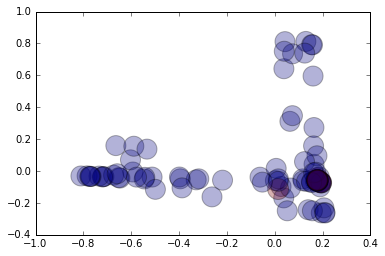

In [51]:
#print X_imputed_scaled_pca
pca1 = X_imputed_scaled_pca.take(0, axis=1)
pca2 = X_imputed_scaled_pca.take(1, axis=1)
#print pca1
plt.scatter(pca1, pca2, c=y*40, s=(y+10)*40, alpha = 0.3)

Trying a RandomForest

In [52]:
clf1 = RandomForestClassifier(n_estimators=30, random_state=123)
print cross_val_score(clf1, X_new_scaled, y, scoring='recall').mean()

0.111111111111


Trying kernel SVM

In [53]:
clf2 = SVC(random_state=23, kernel='rbf', C=0.1, gamma=0.1)
clf2.fit(X_new_scaled, y)
print cross_val_score(clf2, X_new_scaled, y, scoring='recall').mean()

0.0


In [54]:
y[y==0].size / float(y.size)

0.875

##### Appendix: See how "final_project_dataset_modified.pkl" is different from "final_project_dataset.pkl"

In [ ]:
dm = pickle.load(open("final_project_dataset_modified.pkl"))
do = d

In [ ]:
len(dm)

In [ ]:
set(do.keys())-set(dm.keys())

In [ ]:
len(dm[dm.keys()[0]])

In [ ]:
do.pop('LAY KENNETH L',"")
do.pop('SKILLING JEFFREY K',"")
do.pop('TOTAL',"")

In [ ]:
len(do)

In [ ]:
do==dm

In [ ]:
set(do.keys())==set(dm.keys())

In [ ]:
set(dm[dm.keys()[0]].keys())-set(do[do.keys()[0]].keys())

In [ ]:
for k in do.keys():
    if do[k] != dm[k]:
        print k

##### Appendix 2: Miscellaneous experiments

In [71]:
from sklearn.cross_validation import KFold, StratifiedKFold

In [76]:
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,1])
skf = StratifiedKFold(labels, random_state=123)
for train, test in skf:
    print("%s %s" % (labels[train], test))

[0 0 0 0 0 0 0 1 1] [ 0  1  2  3 11]
[0 0 0 0 0 0 0 1 1] [ 4  5  6  7 12]
[0 0 0 0 0 0 0 0 1 1] [ 8  9 10 13]


In [79]:
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,1])
skf = KFold(10, random_state=123)
for train, test in skf:
    print("%s %s" % (train, test))

[4 5 6 7 8 9] [0 1 2 3]
[0 1 2 3 7 8 9] [4 5 6]
[0 1 2 3 4 5 6] [7 8 9]
